In [626]:
import pandas as pd
import numpy as np
import gc
import math
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import pycircular
from datetime import datetime
from math import sin, cos, pi
from random import randint, uniform
from xgboost import XGBClassifier
import sklearn


In [562]:
# Load the competition data
df = pd.read_csv("competition_data.csv")

## Análisis de las variables numéricas

Las variables *product_id* y *user_id* no las tendremos en cuenta porque en su mayor proporción se encuentran vacias y no aportan información a la predicción. 
Por otro lado, notamos 4365 registros con muchas columnas nulas en nustro dataset. Algunos de estos registros estan presentes en la base de testing, por eso se decide no hacer estimaciones de estos valores ya que la base de testing es un reflejo de la realidad y no debería ser alterado. 

En el siguiente bloque de código se muestran los registros con columnas con gran proporcion de informacion nula...

In [563]:
df_num = df.select_dtypes(include='number')

In [564]:
mask = df_num["avg_gmv_item_domain_30days"].isna()
del df_num
df[mask]


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
80,True,931,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,83887,321,36382,340b7d69-ee64-4dba-99c7-03066dbcb5f3,436633616.0,Garantía del vendedor: 30 días,NaN
89,True,1000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,80838,19,6089,60f2a17a-5f37-4238-9b68-85c250bed879,83963350.0,Garantía del vendedor: 6 meses,NaN
93,True,965,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,7997283,661,176129,028c9df1-483a-451f-b206-59d2b3aca377,87061384.0,NaN,NaN
135,True,600,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,13523,187,49282,0615356b-9074-4852-b3de-abd937b17362,533754597.0,Sin garantía,NaN
168,True,10,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,9608,32,3615,ad951016-9fe1-4724-8c53-b4c96f6626f2,317777998.0,Garantía de fábrica: 1 años,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199681,True,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,4120792,87,57957,45b4e692-868d-44b9-a9d7-27019e32b408,87070874.0,NaN,18920.0
199697,True,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,8711980,28,57084,8ee8eb73-beb3-45f3-abb6-c30d36d92da7,132089611.0,NaN,18936.0
199712,True,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,77042,9,27758,35d2fa9f-0a72-4a74-93bb-47d17fe3e397,389010382.0,1 año MAKITA Argentina,18951.0
199856,True,700,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,102610,170,289510,21b5457b-48d3-4ffa-b7f8-a711de5cf8f8,158340181.0,Garantía del vendedor: 6 meses,19095.0


In [565]:
df.drop(columns=["product_id", "user_id"])

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,warranty,ROW_ID
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,Garantía de fábrica: 12 meses,NaN
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,NaN,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,Garantía de fábrica: 90 días,NaN
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,Garantía del vendedor: 90 días,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,True,63,84.123902,313.907255,533.642333,2.987805,6.941176,8.313725,0.001,False,...,354.0,351.0,45.0,424.0,18760,2335,40417,55334ea2-c2c6-4ccd-9bf6-b908e5bc86fb,Sin garantía,19206.0
199968,True,23256,393.334230,137.436786,256.548667,5.258486,8.517857,10.178571,0.001,False,...,477.0,2062.0,118.0,570.0,116834,20807,34928,1199b787-8c80-4343-87ab-c1f1a0518f09,Garantía del vendedor: 20 días,19207.0
199969,True,20,235.246741,327.451321,578.497333,5.096722,14.000000,16.358491,0.001,False,...,742.0,53302.0,124.0,867.0,1750218,8478,35749,225557fd-4680-4504-9e6e-55d851057fd6,Sin garantía,19208.0
199970,True,45,53.861782,102.352949,266.117667,1.636275,3.807692,3.987179,0.001,False,...,297.0,18477.0,5.0,311.0,2644322,288,21052,23a4199b-e884-45b1-9b6e-1de56b0937ef,NaN,19209.0


## Análisis las variables categoricas

In [566]:
df_categoricas = df.select_dtypes(include='object')

In [567]:
for column in df_categoricas:  
   print(column) 
   print(df_categoricas[column].nunique())
   print("\t")

category_id
2284
	
date
31
	
deal_print_id
196744
	
domain_id
1742
	
etl_version
1
	
full_name
2280
	
is_pdp
2
	
item_id
27695
	
listing_type_id
2
	
logistic_type
7
	
main_picture
26961
	
platform
4
	
print_server_timestamp
196780
	
site_id
1
	
tags
1227
	
title
26745
	
uid
159996
	
warranty
1288
	


#### Primer Analisis

Conclusiones:
- Se eliminan las variables de id (category_id, deal_print_id, domain_id, item_id) del analisis: no son representativas para la prediccion.
- se separan las variables temporales (date, print_server_timestamp) para analisis posterior.
- se elimina las variables etl_version, site_id al tener solo una categoria.
- se elimina las variables full_name, main_picture, tags, title, uid y warranty porque no es representativa.
- is_pdp, listing_type_id, logistic_type y platform pueden resultar interesantes para el analisis.
  
Procedemos a analizar las variables: is_pdp, listing_type_id y logistic_type.

#### Variables Categoricas

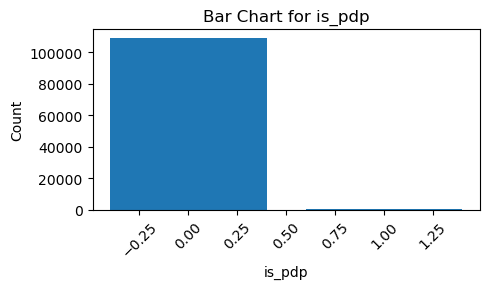

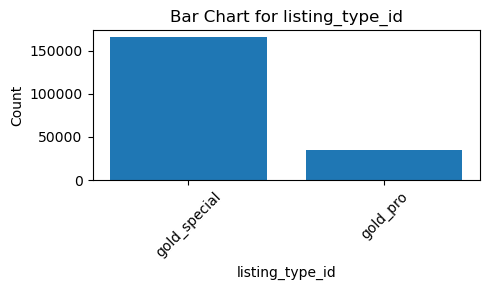

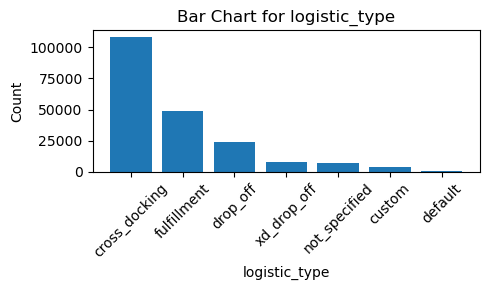

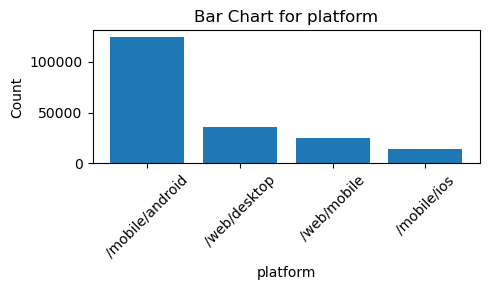

In [568]:
# Analicemos las variables no numericas de nuestro Dataset
df_categoricas = df_categoricas[["is_pdp","listing_type_id","logistic_type", "platform"]]

# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas:  
    categories = df_categoricas[column].value_counts().index
    values = df_categoricas[column].value_counts().values
    

    plt.figure(figsize=(5, 3))  # Tamaño del gráfico (opcional)
    plt.bar(categories, values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.tight_layout()  # Ajustar el diseño
    plt.show()

#### Segundo Analisis:
- is_pdp presenta valores nulos tanto en train como en test, por lo que se decide no estimarlos ni eliminarlos. Se tomaran los registros nan como un posible valor y para normalizar la variable se utiliza One Hot Encoding. Como resultado, se agregaran dos columnas, ya que la tercera se da por entendida cuanda ambas sean falsas.
- listing_type se transforma a una variable booleana que es 1 cuando el listing es gold_special
- Se cree que el tipo de logistica no tiene una relacion natural con la variable resultado. Uno no decide si hacer una compra o no segun el tipo de logistica que utilice el comerciante para transportar su producto. Pero se procede a evaluar si existe una correlacion empirica. En caso de no haberla, se descartara la variable del analisis. 
- Se realizara OneHotEncoding sobre la variable platform.   

In [569]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['logistic_type'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 761.455399863375
P-value: 3.269950268794381e-161


Como resulta significativa la prueba de chi-cuadrado, se concluye que la variable logistic_type presenta una correlacion empirica. Es por eso que se decide hacer OneHotEncoding con la misma.

Realizamos one hot-encoding en la variable categoria *is_pdp*.

In [570]:
# One Hot-Encoding
df = pd.get_dummies(df, 
    sparse=True,
    columns=[
        "logistic_type", 
        "platform", 
        "is_pdp"
    ],
    dtype=int
)

Convirtamos la variable categoria *listing_type_id* en booleana. Esta no presenta valores nulos. Si es gold_special será 1 y si es gold_pro será 0.

In [571]:
df["listing_type_id"] = df["listing_type_id"].apply(lambda x: 1 if x == "True" else 0)

## Variables Temporales

Las variables temporales pueden influir mucho en el comportamiento del consumidor. Se debe evaluar y tener en cuenta el momento en el que estan visitando la pagina ya que puede determinar si se realiza o no la conversion. Es por eso que se realiza un encoding de estas variables.

In [572]:
# Modificamos el tipo de datos a datetime.
df["date"] = pd.to_datetime(df["date"])
df["print_server_timestamp"] = pd.to_datetime(df["print_server_timestamp"])
df[["date","print_server_timestamp"]]

,date,print_server_timestamp
0,2020-03-06,2020-03-06 00:19:30.735000-04:00
1,2020-04-01,2020-04-01 21:20:11.738000-04:00
2,2020-04-08,2020-04-08 18:38:48.360000-04:00
3,2020-04-25,2020-04-25 22:01:19.829000-04:00
4,2020-03-10,2020-03-10 13:20:56.633000-04:00
...,...,...
199967,2020-04-12,2020-04-12 14:35:44.784000-04:00
199968,2020-04-03,2020-04-03 17:32:53.035000-04:00
199969,2020-04-01,2020-04-01 22:51:08.898000-04:00
199970,2020-04-08,2020-04-08 11:32:27.563000-04:00


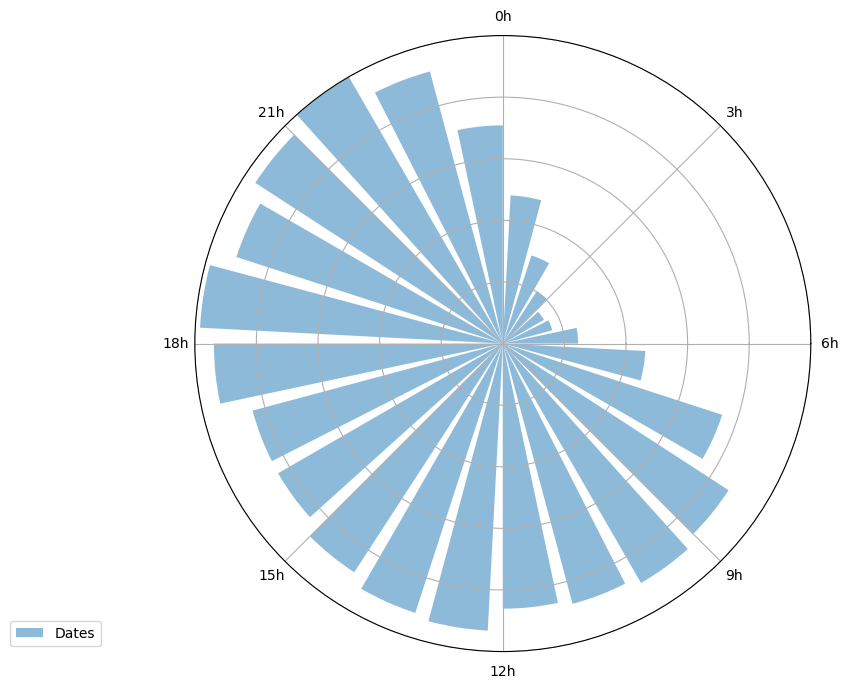

In [573]:
time_segment = 'hour'  
freq_arr, times = pycircular.utils.freq_time(df["print_server_timestamp"] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Combinando las funciones seno y coseno podemos caracterizar una variable cíclica. Esto se simula de esta manera para que las variables tengan un sentido ciclico y no lineal. Por ejemplo, en el caso de las horas la hora 00 y la hora 23 en la realidad estan muy cerca una de la otra. Si se las analiza linealmente perderian esta propiedad, pero si se les hace un encoding calculando sus seno y coseno se mantendria. 
Se realizara este analisis con las horas, los dias de la semana y los dias del mes.
No se realiza sobre el mes porque solo hay dos meses.

Para las horas:

In [574]:
# Unidad de tiempo:
cantidad_tiempo = 24

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))

df['hour_sin'] = seno
df['hour_cos'] = coseno


Para los dias de la semana:

In [575]:
# Unidad de tiempo:
cantidad_tiempo = 7

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))

df['weekday_sin'] = seno
df['weekday_cos'] = coseno

Para los dias del mes:

In [576]:
# Como solo hay mes 3 y 4 aplicamos una regla para determinar la cantidad de dias en cada uno de los meses:
df["days_in_month"] = df["print_server_timestamp"].dt.month.apply(lambda x: 31 if x == 3 else 30)

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))
coseno = np.cos((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))

df['day_sin'] = seno
df['day_cos'] = coseno

df = df.drop(columns = ["days_in_month"])


In [577]:
df = df.drop(columns = ["date","print_server_timestamp"])

In [578]:
df.head()

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,platform_/web/desktop,platform_/web/mobile,is_pdp_False,is_pdp_True,hour_sin,hour_cos,weekday_sin,weekday_cos,day_sin,day_cos
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,1,0,1,0,0.000000,1.000000e+00,-0.433884,-0.900969,0.937752,0.347305
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,0,0,1,0,-0.707107,7.071068e-01,0.974928,-0.222521,0.207912,0.978148
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,0,0,1,0,-1.000000,-1.836970e-16,0.974928,-0.222521,0.994522,-0.104528
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,0,1,1,0,-0.500000,8.660254e-01,-0.974928,-0.222521,-0.866025,0.500000
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,0,0,1,0,-0.258819,-9.659258e-01,0.781831,0.623490,0.897805,-0.440394


# Exploración e Implementación del Modelo 

Una vez finalizado el analisis exploratorio de datos (EDA), se procede a la exploracion e implementacion del modelo.

- Train: 80%
- Val: 20%
- Test: de testeo.

In [579]:
# Split into training and evaluation samples
train_data = df[df["ROW_ID"].isna()]
test_data = df[df["ROW_ID"].notna()]
del(df)

In [580]:
train_data = train_data.select_dtypes(include='number')
train_data = train_data.drop(columns=["ROW_ID"])
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=["conversion"]), train_data['conversion'], test_size=0.2)
del train_data

In [522]:
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

## XG Boost

In [651]:
%%capture
model_xgb_1 = XGBClassifier(n_jobs=3, use_label_encoder=False)

Se realiza una primera prueba haciendo un unico job, pocas iteraciones y pocos splits en el cross validation con el fin de que demore poco y ver la performance rapidamente:

In [582]:
%%capture
param_dist_1 = {'max_depth': stats.randint(1,20),
              'learning_rate': stats.uniform(0.01, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
# Cross Validation
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_1 = RandomizedSearchCV(model_xgb_1,param_dist_1, cv=cv, verbose=1, n_jobs=1,scoring='roc_auc',n_iter=3,random_state=41)
xgb_random.fit(X_train,y_train)

Los siguientes parametros fueron los que mejor performance le dieron al modelo:

In [650]:
xgb_random_1.best_params_

{'colsample_bytree': 0.7726522317254072,
 'learning_rate': 0.05504289822495324,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 624,
 'subsample': 0.8630029043748595}

El siguiente valor representa la performance del modelo (con un unico job):

In [584]:
xgb_random_1.best_score_

0.8896318332766606

In [585]:
# Predict on the evaluation set
y_pred_1 = xgb_random_1.predict_proba(X_test)[:,1]
y_pred_1

array([0.01771883, 0.00182922, 0.03776919, ..., 0.006544  , 0.02112205,
       0.00123799], dtype=float32)

In [587]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_1})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.1.csv", sep=",", index=False)

En la base de test publica del Kaggle el modelo retorno una performance de: 0.88723

Prueba 2 (mejorando los parametros): 


In [597]:
%%capture
param_dist_2 = {'max_depth': stats.randint(5,12),
              'learning_rate': stats.uniform(0.01, 0.1),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

xgb_random_2 = RandomizedSearchCV(model_xgb_2,param_dist_2, cv=cv, verbose=1, n_jobs=5,scoring='roc_auc',n_iter=20,random_state=41)
xgb_random_2.fit(X_train,y_train)

In [608]:
xgb_random_2.best_params_

{'colsample_bytree': 0.6132378121429716,
 'learning_rate': 0.033917082477347975,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 515,
 'subsample': 0.8452823549192477}

In [604]:
xgb_random_2.best_score_

0.8955689746154285

In [609]:
# Print the accuracy for each iteration
for i, score in enumerate(xgb_random_2.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: auc_roc = {score:.4f}")

Iteraciones 1: auc_roc = 0.8778
Iteraciones 2: auc_roc = nan
Iteraciones 3: auc_roc = 0.8952
Iteraciones 4: auc_roc = 0.8956
Iteraciones 5: auc_roc = 0.8925
Iteraciones 6: auc_roc = 0.8943
Iteraciones 7: auc_roc = nan
Iteraciones 8: auc_roc = 0.8888
Iteraciones 9: auc_roc = 0.8789
Iteraciones 10: auc_roc = 0.8936
Iteraciones 11: auc_roc = 0.8952
Iteraciones 12: auc_roc = 0.8954
Iteraciones 13: auc_roc = nan
Iteraciones 14: auc_roc = 0.8906
Iteraciones 15: auc_roc = 0.8808
Iteraciones 16: auc_roc = 0.8936
Iteraciones 17: auc_roc = 0.8849
Iteraciones 18: auc_roc = nan
Iteraciones 19: auc_roc = 0.8922
Iteraciones 20: auc_roc = 0.8942


In [606]:
# Predict on the evaluation set
y_pred_2 = xgb_random_2.predict_proba(X_test)[:,1]
y_pred_2

array([3.90735380e-02, 1.11181784e-04, 1.34105936e-01, ...,
       1.73342705e-04, 9.93781388e-02, 9.33930132e-05], dtype=float32)

In [628]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_2})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.2.csv", sep=",", index=False)

Mejoró el modelo con la base publica del del kaggle!
Performance de 0.88977

#### Ahora utilicemos los parametros que mejor performance dieron para volver a entrenar los datos.

Prueba 3:

In [638]:
%%capture
param_dist_3 = {'max_depth': stats.randint(5,7),
              'learning_rate': stats.uniform(0.01, 0.05),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.3, 0.9),
              'min_child_weight': stats.randint(2,4),
              'n_estimators': stats.randint(200, 1000)
             }
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

xgb_random_3 = RandomizedSearchCV(model_xgb_3,param_dist_3, cv=cv, verbose=1, n_jobs=5,scoring='roc_auc',n_iter=20,random_state=41)
xgb_random_3.fit(X_train,y_train)

In [641]:
xgb_random_3.best_params_

{'colsample_bytree': 0.7726522317254072,
 'learning_rate': 0.05504289822495324,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 624,
 'subsample': 0.8630029043748595}

In [642]:
xgb_random_3.best_score_

0.8957945096960529

In [643]:
# Print the accuracy for each iteration
for i, score in enumerate(xgb_random_3.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: auc_roc = {score:.4f}")

Iteraciones 1: auc_roc = 0.8843
Iteraciones 2: auc_roc = nan
Iteraciones 3: auc_roc = 0.8949
Iteraciones 4: auc_roc = nan
Iteraciones 5: auc_roc = 0.8955
Iteraciones 6: auc_roc = 0.8866
Iteraciones 7: auc_roc = 0.8922
Iteraciones 8: auc_roc = 0.8940
Iteraciones 9: auc_roc = 0.8930
Iteraciones 10: auc_roc = 0.8876
Iteraciones 11: auc_roc = 0.8927
Iteraciones 12: auc_roc = 0.8958
Iteraciones 13: auc_roc = nan
Iteraciones 14: auc_roc = 0.8952
Iteraciones 15: auc_roc = 0.8912
Iteraciones 16: auc_roc = nan
Iteraciones 17: auc_roc = 0.8871
Iteraciones 18: auc_roc = 0.8926
Iteraciones 19: auc_roc = nan
Iteraciones 20: auc_roc = 0.8901


In [647]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_3})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.3.csv", sep=",", index=False)